In [1]:
import pandas as pd 
import numpy as np 
import sys
import os

# Load other functions
sys.path.append(os.path.abspath('../src'))
sys.path.append(os.path.abspath('../scripts'))

from Load_data import CSVDataloader, get_file_path
from EDA import univariate_analysis, bivariate_analysis, merge_datasets, analyze_class_distribution
from preprocessing import preprocess
from models import train_logistic_regression, train_ensemble_model, evaluate_model, train_rf_with_best, train_xgb_with_best, evaluate_model1
from hyperparameter_search import search_best_params_rf, search_best_params_xgb


In [2]:
# Load credit data
credit_path = get_file_path("credit")
credit_loader = CSVDataloader(credit_path)
df_credit = credit_loader.load_data()

# Load fraud data
fraud_path = get_file_path("fraud")
fraud_loader = CSVDataloader(fraud_path)
df_fraud = fraud_loader.load_data()

# Load IPAddress data
IPAddress_path = get_file_path("IpAddresss")
IPAddress_loader = CSVDataloader(IPAddress_path)
df_Address = IPAddress_loader.load_data()


In [3]:
# Load credit dataset
df_credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
# Load credit dataset
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2/24/2015 22:55,4/18/2015 2:47,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,6/7/2015 20:39,6/8/2015 1:38,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,1/1/2015 18:52,1/1/2015 18:52,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,4/28/2015 21:13,5/4/2015 13:54,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,7/21/2015 7:09,9/9/2015 18:40,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [5]:
df_Address.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


## Data Analysis and Preprocessing

In [6]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [12]:
df_fraud.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [27]:
print("\nMissing values in fraud dataset:")
df_fraud.isna().sum()


Missing values in fraud dataset:


user_id           0
signup_time       0
purchase_time     0
purchase_value    0
device_id         0
source            0
browser           0
sex               0
age               0
ip_address        0
class             0
dtype: int64

In [26]:
# Check for missing values in IP address dataset
print("\nMissing values in IP address dataset:")
print(df_Address.isnull().sum())



Missing values in IP address dataset:
lower_bound_ip_address    0
upper_bound_ip_address    0
country                   0
dtype: int64


In [28]:
# Check for duplicates in fraud dataset
print("\nDuplicate rows in fraud dataset before cleaning:", df_fraud.duplicated().sum())


Duplicate rows in fraud dataset before cleaning: 0


In [29]:
# Check for duplicates in IP address dataset
print("\nDuplicate rows in IP address dataset before cleaning:", df_Address.duplicated().sum())


Duplicate rows in IP address dataset before cleaning: 0


#### Correct Data Types
df_fraud['ip_address'] is currently a float64. Since IP addresses are stored as numeric IDs (likely converted from dotted format), I will convert it to integers.

In [7]:
# Check current data types
print("\nFraud dataset data types before correction:")
print(df_fraud.dtypes)


Fraud dataset data types before correction:
user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object


In [8]:
# Convert ip_address from float to int
df_fraud['ip_address'] = df_fraud['ip_address'].astype('int64')

In [9]:
# Convert datetime columns in fraud dataset
df_fraud['signup_time'] = pd.to_datetime(df_fraud['signup_time'])
df_fraud['purchase_time'] = pd.to_datetime(df_fraud['purchase_time'])

In [8]:
# Convert class to boolean (since it's binary)
df_fraud['class'] = df_fraud['class'].astype(bool)

In [10]:
# Verify data types after conversion
print("\nFraud dataset data types after correction:")
print(df_fraud.dtypes)


Fraud dataset data types after correction:
user_id                    int64
signup_time       datetime64[ns]
purchase_time     datetime64[ns]
purchase_value             int64
device_id                 object
source                    object
browser                   object
sex                       object
age                        int64
ip_address                 int64
class                      int64
dtype: object


In [11]:
print("\nIP address dataset data types before correction:")
print(df_Address.dtypes)


IP address dataset data types before correction:
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object


In [12]:
# For IP address dataset, ensure numeric columns are correct
df_Address['lower_bound_ip_address'] = df_Address['lower_bound_ip_address'].astype('int64')
df_Address['upper_bound_ip_address'] = df_Address['upper_bound_ip_address'].astype('int64')
df_Address['country'] = df_Address['country'].astype('category')

In [13]:
print("\nIP address dataset data types after correction:")
print(df_Address.dtypes)


IP address dataset data types after correction:
lower_bound_ip_address       int64
upper_bound_ip_address       int64
country                   category
dtype: object


## Univariate analysis

Starting Univariate Analysis...


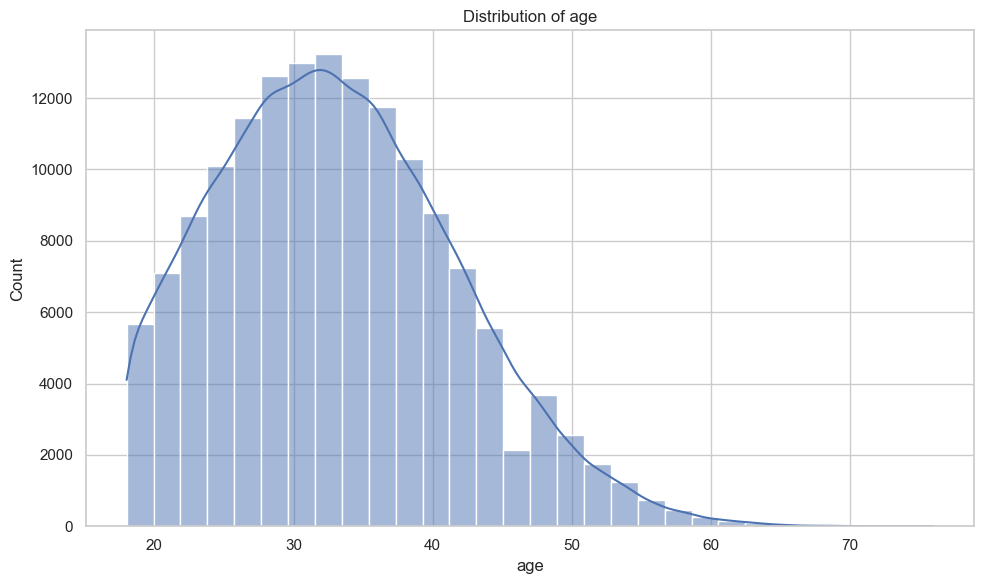

In [ ]:
print("Starting Univariate Analysis...")
univariate_analysis(df_fraud, "age")

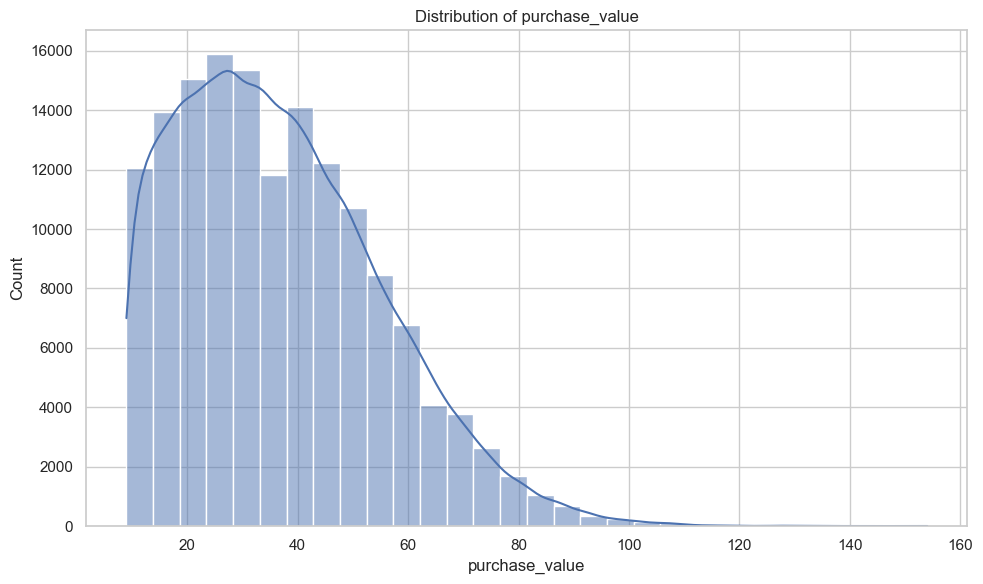

In [13]:
univariate_analysis(df_fraud, "purchase_value")

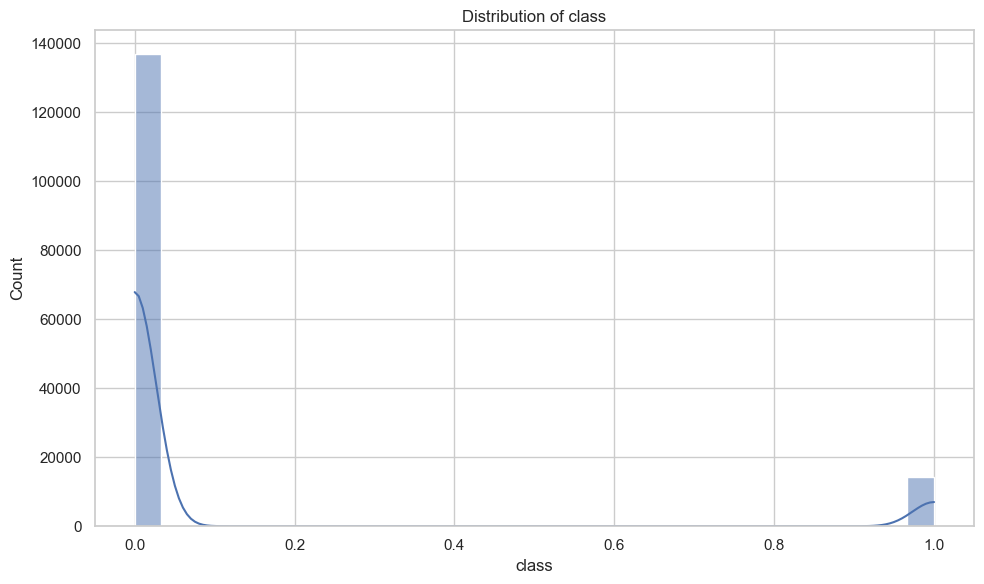

In [18]:
univariate_analysis(df_fraud, "class")

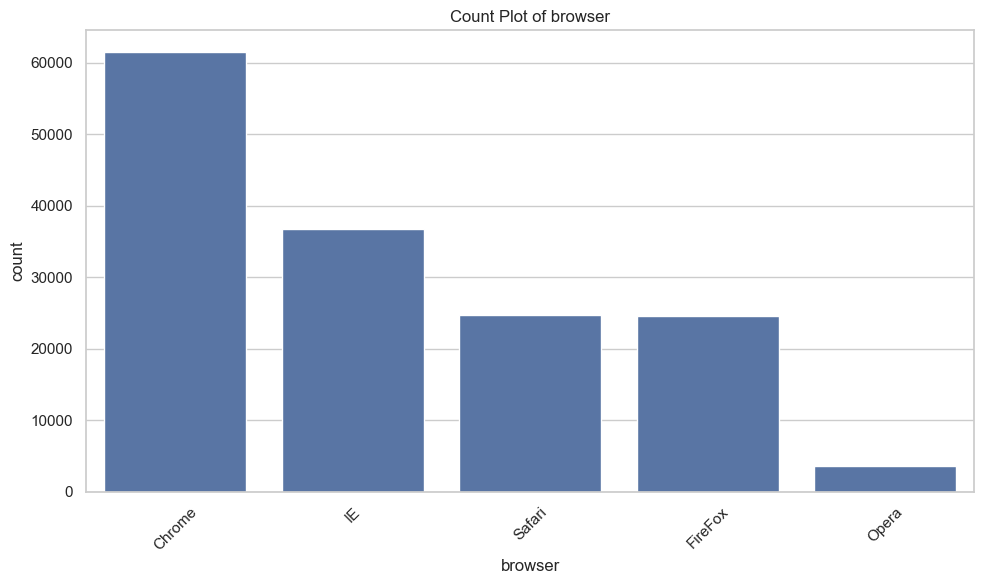

In [15]:
univariate_analysis(df_fraud, "browser")

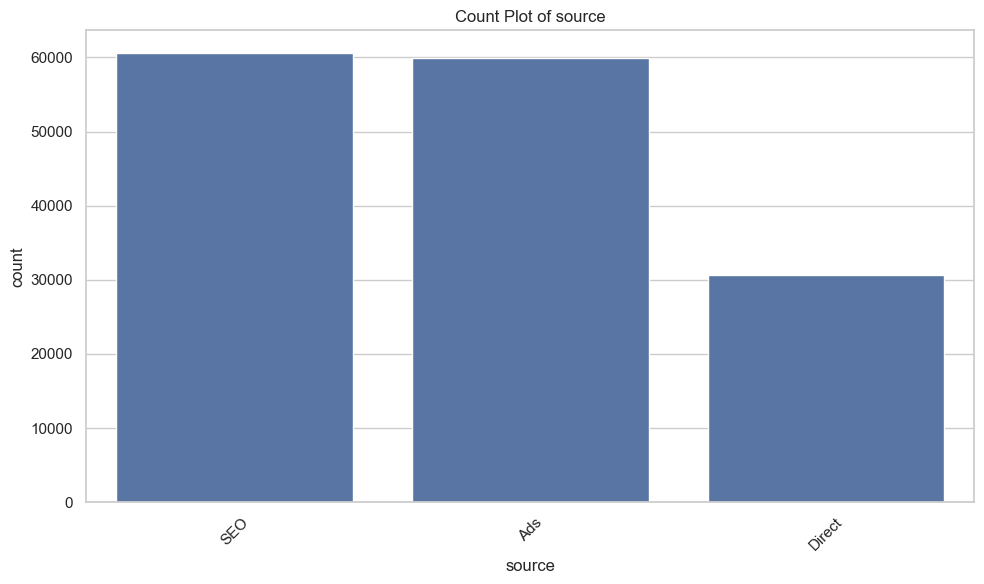

In [16]:
univariate_analysis(df_fraud, "source")

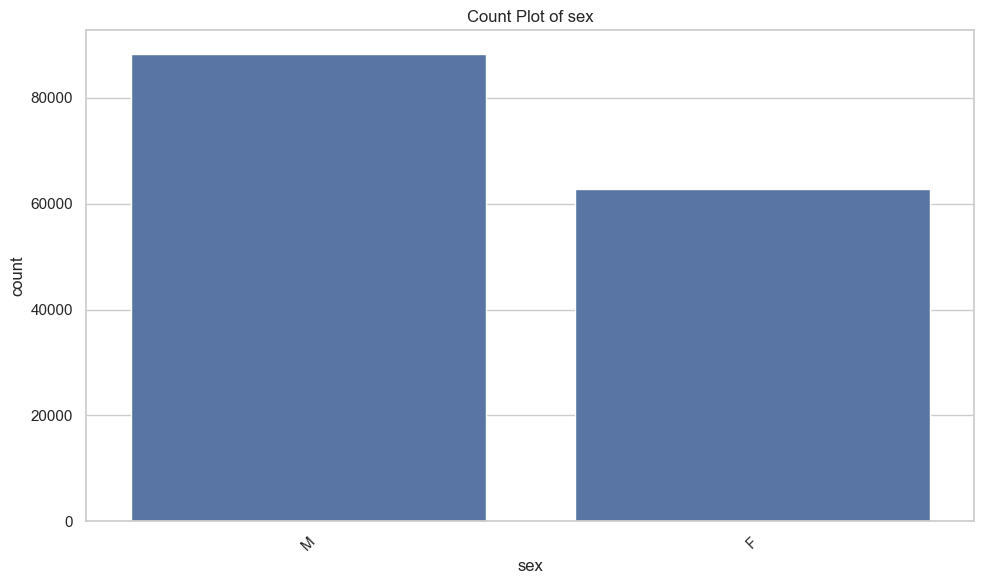

In [17]:
univariate_analysis(df_fraud, "sex")

## Bivariate analysis

Starting Bivariate Analysis...


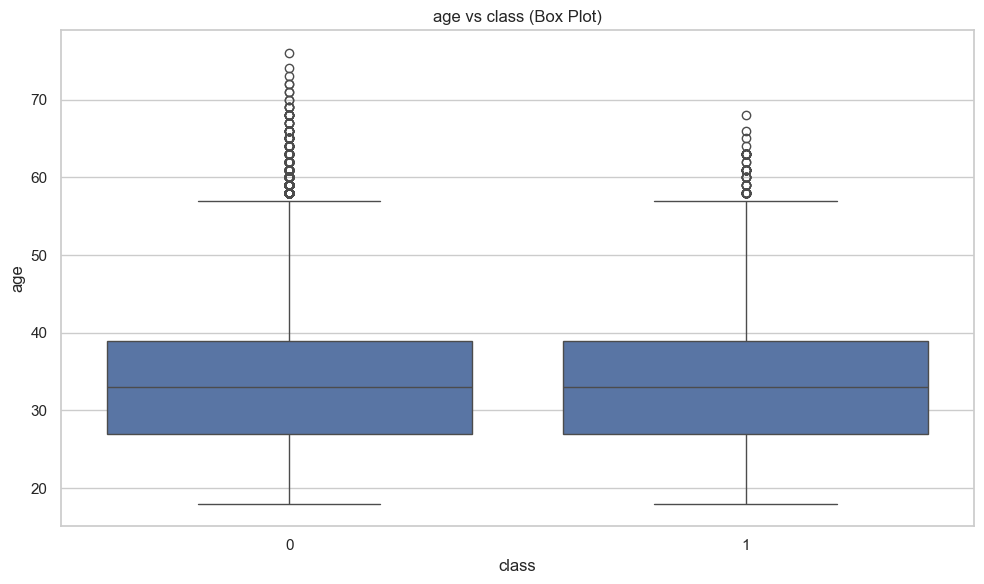

In [19]:
print("Starting Bivariate Analysis...")
bivariate_analysis(df_fraud, "age", "class")

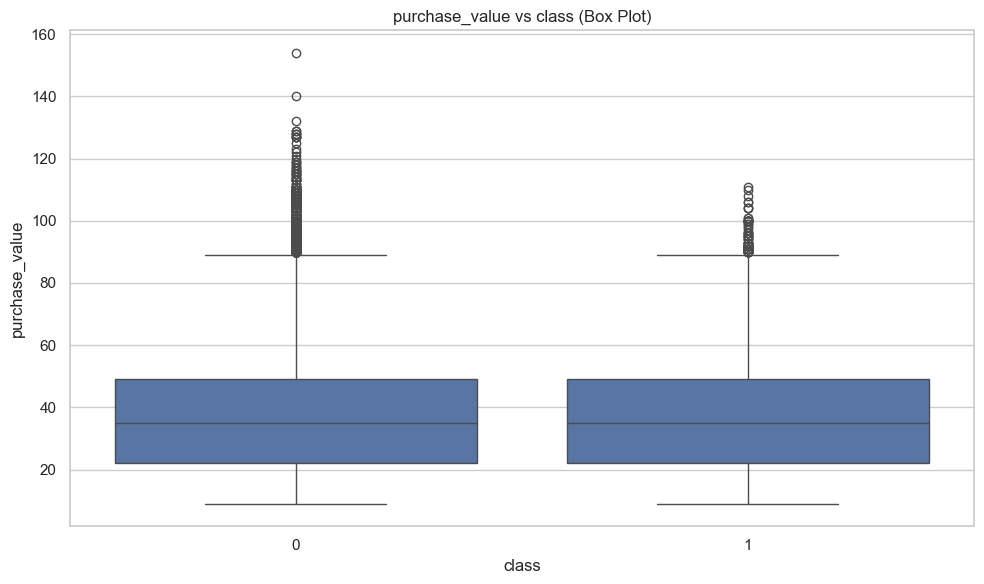

In [21]:
bivariate_analysis(df_fraud, "purchase_value", "class")

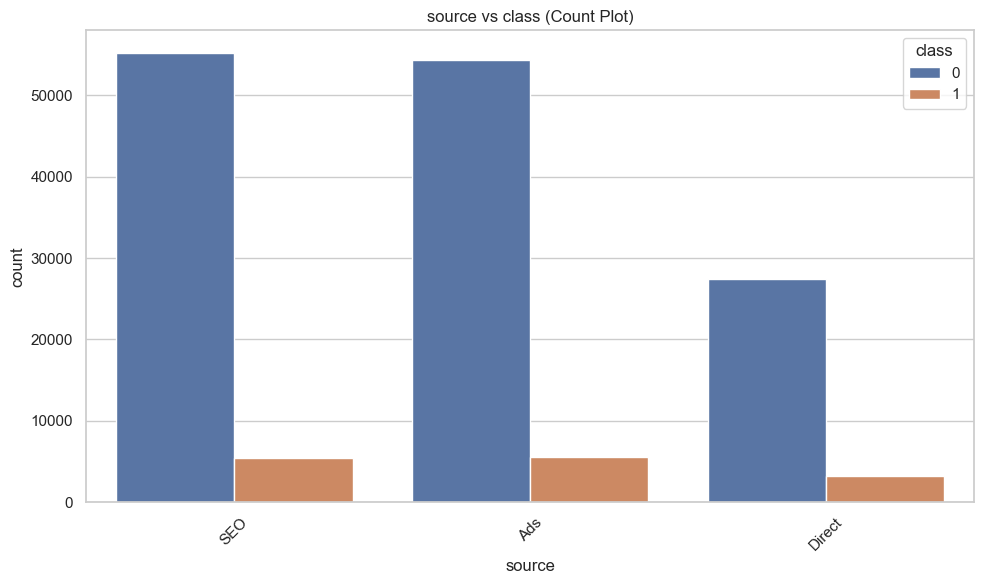

In [22]:
bivariate_analysis(df_fraud, "source", "class")

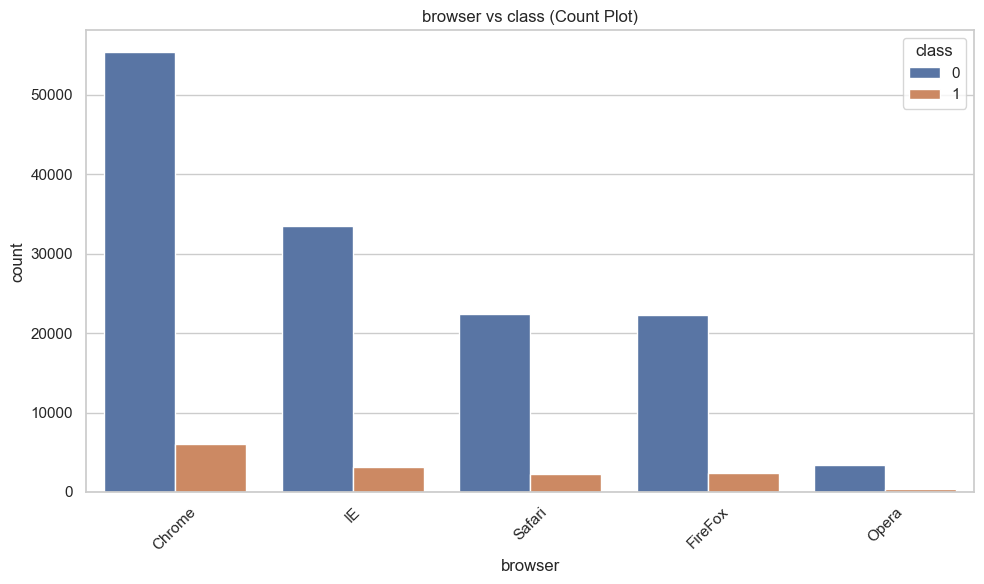

In [23]:
bivariate_analysis(df_fraud, "browser", "class")

### Merge Datasets for Geolocation Analysis

In [14]:
merged_df = merge_datasets(df_fraud, df_Address)


In [15]:
print(merged_df.head())

   user_id         signup_time       purchase_time  purchase_value  \
0    22058 2015-02-24 22:55:00 2015-04-18 02:47:00              34   
1   333320 2015-06-07 20:39:00 2015-06-08 01:38:00              16   
2     1359 2015-01-01 18:52:00 2015-01-01 18:52:00              15   
3   150084 2015-04-28 21:13:00 2015-05-04 13:54:00              44   
4   221365 2015-07-21 07:09:00 2015-09-09 18:40:00              39   

       device_id source browser sex  age  ip_address  class    ip_numeric  \
0  QVPSPJUOCKZAR    SEO  Chrome   M   39   732758368      0  7.327584e+08   
1  EOGFQPIZPYXFZ    Ads  Chrome   F   53   350311387      0  3.503114e+08   
2  YSSKYOSJHPPLJ    SEO   Opera   M   53  2621473820      1  2.621474e+09   
3  ATGTXKYKUDUQN    SEO  Safari   M   41  3840542444      0  3.840542e+09   
4  NAUITBZFJKHWW    Ads  Safari   M   45   415583117      0  4.155831e+08   

         country  
0          Japan  
1  United States  
2  United States  
3            NaN  
4  United States  


## Handling Class Imbalance in Fraud Detection
I'll implement a comprehensive solution for handling class imbalance in the fraud dataset, analyzing the distribution and applying appropriate sampling techniques.

#### Analyze Class Distribution

Class Distribution:
class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


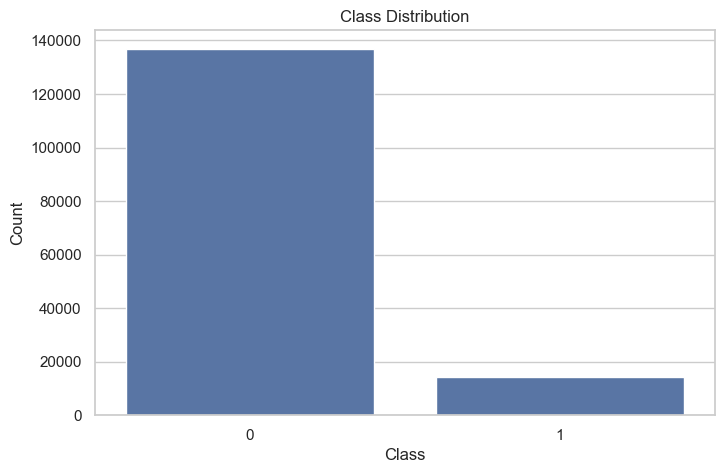

{'class_counts': {0: 136961, 1: 14151},
 'class_ratios': {0: 0.9063542273280746, 1: 0.09364577267192546}}

In [16]:
analyze_class_distribution(merged_df)

In [17]:
prepro = preprocess(merged_df)

### Feature Engineering

In [18]:
feature_engineered = prepro.engineer_features()

Engineering transaction frequency and velocity features...
Engineering time-based features...
Calculating time since signup...
Creating additional features...


In [19]:
feature_engineered.to_csv('../Data/preprocessed_merged.csv')

In [2]:
df = pd.read_csv('../Data/preprocessed_merged.csv')

In [3]:
df.head()

,Unnamed: 0,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,...,ip_numeric,country,time_since_last_txn,txn_count,hour_of_day,day_of_week,time_of_day,time_since_signup,is_weekend,browser_popularity
0,116708,2,2015-01-11 03:47:00,2015-02-21 10:03:00,54,FGBQNDNBETFJJ,SEO,Chrome,F,25,...,8.802175e+08,United States,NaN,1,10,5,Morning,990.266667,1,0.406533
1,15108,4,2015-06-02 16:40:00,2015-09-26 21:32:00,41,MKFUIVOHLJBYN,Direct,Safari,F,38,...,2.785906e+09,Switzerland,NaN,1,21,5,Evening,2788.866667,1,0.163237
2,46047,8,2015-05-28 07:53:00,2015-08-13 11:53:00,47,SCQGQALXBUQZJ,SEO,Chrome,M,25,...,3.560567e+08,United States,NaN,1,11,3,Morning,1852.000000,0,0.406533
3,67650,9,2015-05-16 15:58:00,2015-05-20 23:06:00,62,IEZOHXPZBIRTE,SEO,FireFox,M,21,...,7.591047e+08,NaN,NaN,1,23,2,Evening,103.133333,0,0.162859
4,109067,12,2015-01-10 06:25:00,2015-03-04 20:56:00,35,MSNWCFEHKTIOY,Ads,Safari,M,19,...,2.985180e+09,Mexico,NaN,1,20,2,Evening,1286.516667,0,0.163237


In [17]:
df.columns

Index(['Unnamed: 0', 'user_id', 'signup_time', 'purchase_time',
       'purchase_value', 'device_id', 'source', 'browser', 'sex', 'age',
       'ip_address', 'class', 'ip_numeric', 'country', 'time_since_last_txn',
       'txn_count', 'hour_of_day', 'day_of_week', 'time_of_day',
       'time_since_signup', 'is_weekend', 'browser_popularity'],
      dtype='object')

In [3]:
df = df.drop(columns=['Unnamed: 0', 'time_since_last_txn', 'device_id', 'sex', 'ip_address', 'signup_time', 'purchase_time'], axis=1)

In [20]:
df.isna().sum()

user_id                   0
signup_time               0
purchase_time             0
purchase_value            0
source                    0
browser                   0
age                       0
class                     0
ip_numeric                0
country               21969
txn_count                 0
hour_of_day               0
day_of_week               0
time_of_day               0
time_since_signup         0
is_weekend                0
browser_popularity        0
dtype: int64

In [5]:
# removing rows that have a country column null 
# Drop rows where 'country' is null
len(df)

151112

In [4]:
df = df.dropna(subset=["country"])
len(df)

129143

In [6]:
# Display the new features
print(df[['user_id', 'purchase_time', 'txn_count', 'hour_of_day', 'day_of_week', 
                    'time_since_signup']].head())

   user_id        purchase_time  txn_count  hour_of_day  day_of_week  \
0        2  2015-02-21 10:03:00          1           10            5   
1        4  2015-09-26 21:32:00          1           21            5   
2        8  2015-08-13 11:53:00          1           11            3   
4       12  2015-03-04 20:56:00          1           20            2   
5       16  2015-03-12 12:46:00          1           12            3   

   time_since_signup  
0         990.266667  
1        2788.866667  
2        1852.000000  
4        1286.516667  
5         886.966667  


In [9]:
# After running engineer_features(), you can analyze the new features:
import matplotlib.pyplot as plt
# 1. Analyze transaction velocity
velocity_stats = df.groupby('class')['time_since_signup'].describe()
print("\nTransaction velocity statistics by fraud class:")
print(velocity_stats)


Transaction velocity statistics by fraud class:
          count         mean         std       min      25%     50%  \
class                                                                 
0      116875.0  1442.288791  830.249054  0.033333  720.275  1444.3   
1       12268.0   667.513566  919.495461  0.000000    0.000     0.0   

               75%          max  
class                            
0      2161.391667  2879.983333  
1      1316.241667  2878.883333  


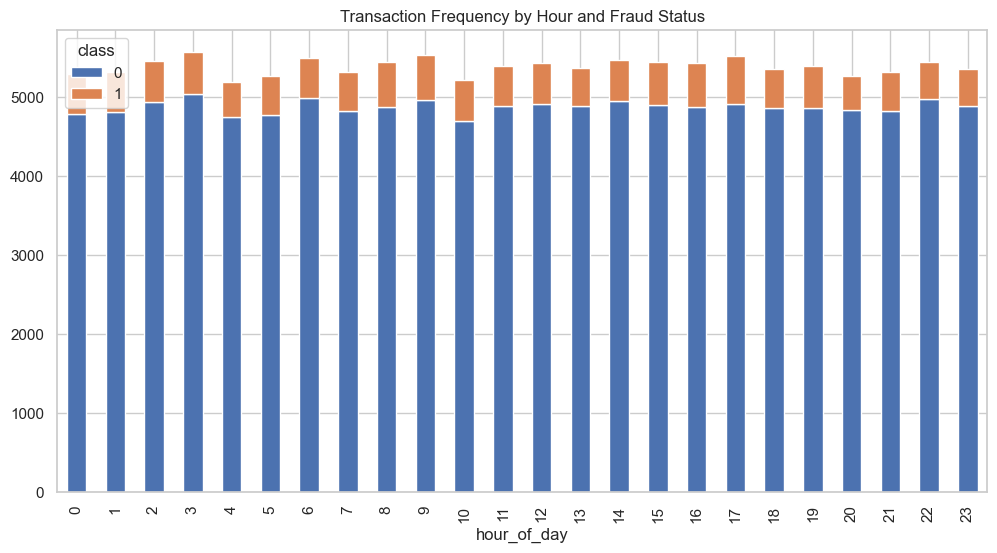

In [27]:
# 2. Analyze time patterns
time_patterns = df.groupby(['hour_of_day', 'class']).size().unstack()
time_patterns.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Transaction Frequency by Hour and Fraud Status')
plt.show()

In [10]:
# 3. Analyze time since signup
signup_analysis = df.groupby('class')['time_since_signup'].describe()
print("\nTime since signup statistics by fraud class:")
print(signup_analysis)


Time since signup statistics by fraud class:
          count         mean         std       min      25%     50%  \
class                                                                 
0      116875.0  1442.288791  830.249054  0.033333  720.275  1444.3   
1       12268.0   667.513566  919.495461  0.000000    0.000     0.0   

               75%          max  
class                            
0      2161.391667  2879.983333  
1      1316.241667  2878.883333  


#### Data Splitting (Before Resampling)

In [5]:
prepro1 = preprocess(df)

In [6]:
X_train, X_test, y_train, y_test = prepro1.split_data()

In [24]:
print(X_train)

        user_id          signup_time        purchase_time  purchase_value  \
45807    121469  2015-02-04 08:14:00  2015-04-22 23:26:00              55   
826        2306  2015-01-20 14:15:00  2015-02-01 21:08:00              43   
101394   268431  2015-02-25 22:26:00  2015-04-15 15:57:00              16   
129925   344071  2015-04-18 23:57:00  2015-06-10 12:13:00              24   
20930     55789  2015-02-26 20:30:00  2015-04-16 22:04:00              32   
...         ...                  ...                  ...             ...   
116632   308844  2015-04-03 05:00:00  2015-05-12 21:24:00              15   
114944   304410  2015-04-02 10:47:00  2015-04-26 19:11:00              44   
75832    200692  2015-04-08 07:06:00  2015-08-03 05:35:00              64   
61433    162732  2015-05-04 04:53:00  2015-08-11 21:04:00              29   
48853    129637  2015-08-01 02:29:00  2015-08-22 21:19:00              56   

        source browser  age    ip_numeric        country  txn_count  \
4580

In [14]:
print(y_train)

45807     0
826       0
101394    0
129925    0
20930     0
         ..
116632    0
114944    0
75832     1
61433     1
48853     0
Name: class, Length: 90400, dtype: int64


In [24]:
X_train.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,ip_numeric,country,txn_count,hour_of_day,day_of_week,time_of_day,time_since_signup,is_weekend,browser_popularity
45807,121469,2015-02-04 08:14:00,2015-04-22 23:26:00,55,BUNFDAXZZLDFO,SEO,Chrome,M,45,981584336,9.815843e+08,China,1,23,2,Evening,1863.200000,0,0.406533
826,2306,2015-01-20 14:15:00,2015-02-01 21:08:00,43,RIQNJNCAVXTZG,Ads,IE,F,38,2067908227,2.067908e+09,China,1,21,6,Evening,294.883333,1,0.243045
101394,268431,2015-02-25 22:26:00,2015-04-15 15:57:00,16,TIDSANCIXYGZD,Ads,Chrome,F,31,299591695,2.995917e+08,United States,1,15,2,Afternoon,1169.516667,0,0.406533
129925,344071,2015-04-18 23:57:00,2015-06-10 12:13:00,24,TKWUUFLBRRQUO,SEO,Chrome,F,46,1772333050,1.772333e+09,Kenya,1,12,2,Afternoon,1260.266667,0,0.406533
20930,55789,2015-02-26 20:30:00,2015-04-16 22:04:00,32,DNYWPFYSXOKYD,SEO,IE,F,39,1870598299,1.870598e+09,China,1,22,3,Evening,1177.566667,0,0.243045


In [8]:
# Convert datetime columns in fraud dataset
X_train['signup_time'] = pd.to_datetime(X_train['signup_time'])
X_train['purchase_time'] = pd.to_datetime(X_train['purchase_time'])

In [7]:
non_numeric_cols = X_train.select_dtypes(include=['object', 'category']).columns
print("Non-numeric columns before SMOTE:", non_numeric_cols)

Non-numeric columns before SMOTE: Index(['source', 'browser', 'country', 'time_of_day'], dtype='object')


In [8]:
X_train = pd.get_dummies(X_train, drop_first=True)
X_test = pd.get_dummies(X_test, drop_first=True)

# Align columns: fill missing columns with 0
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)


In [29]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 90400 entries, 45807 to 48853
Columns: 197 entries, user_id to time_of_day_Night
dtypes: bool(185), datetime64[ns](2), float64(3), int64(7)
memory usage: 24.9 MB


## Sampling Techniques Implementation

#### SMOTE (Synthetic Minority Oversampling Technique)

In [9]:
X_train_smote, y_train_smote = prepro1.apply_smote(X_train, y_train)


After SMOTE:
class
0    81812
1    81812
Name: count, dtype: int64


#### Random Undersampling

In [11]:
X_train_rus, y_train_rus = prepro1.apply_undersampling(X_train, y_train)


After Undersampling:
class
0    8588
1    8588
Name: count, dtype: int64


#### Combined SMOTE + Tomek Links

In [21]:
X_train_smt, y_train_smt = prepro1.apply_smotetomek(X_train, y_train)


After SMOTE + Tomek Links:
class
0    86168
1    86168
Name: count, dtype: int64


## Model Building and Training 

In [10]:
#Use cleaned/SMOTE-applied datasets
X_train_final = X_train_smote 
y_train_final = y_train_smote

## ■	Logistic Regression

=== Logistic Regression Evaluation ===
F1 Score: 0.30124466358006136
AUC-PR: 0.3121296553264099

Confusion Matrix:
[[24617 10446]
 [ 1175  2505]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     35063
           1       0.19      0.68      0.30      3680

    accuracy                           0.70     38743
   macro avg       0.57      0.69      0.56     38743
weighted avg       0.88      0.70      0.76     38743



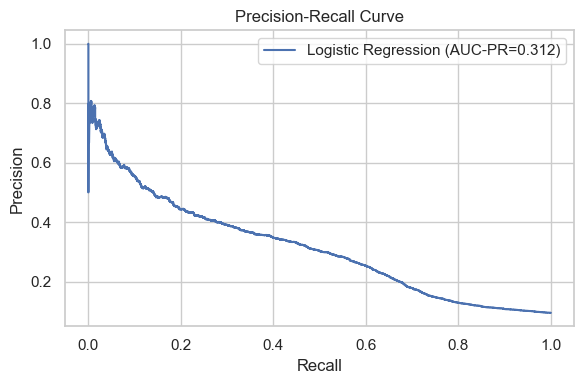

In [13]:
# Logistic Regression
logistic_model = train_logistic_regression(X_train_final, y_train_final)
logistic_eval = evaluate_model(logistic_model, X_test, y_test, model_name="Logistic Regression")

## ■	Ensemble Model

c:\Users\Specter\Documents\Tenx_Academy\Week-8-9\Fraud-Detection-Ecommerce-Banking\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:01:13] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


=== XGBoost Evaluation ===
F1 Score: 0.7074663402692778
AUC-PR: 0.6392260469200464

Confusion Matrix:
[[35047    16]
 [ 1657  2023]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     35063
           1       0.99      0.55      0.71      3680

    accuracy                           0.96     38743
   macro avg       0.97      0.77      0.84     38743
weighted avg       0.96      0.96      0.95     38743



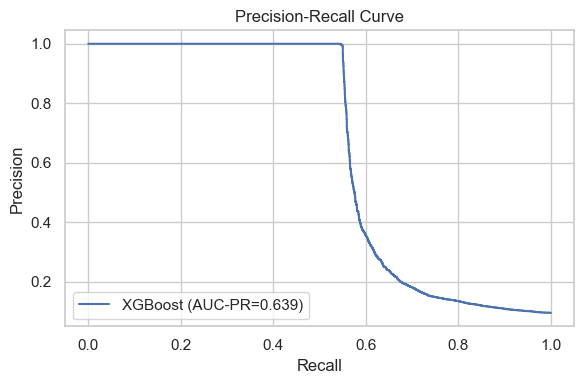

In [14]:
# Ensemble Model (XGBoost or Random Forest)
ensemble_model = train_ensemble_model(X_train_final, y_train_final, model_type="xgboost")  # or 'random_forest'
ensemble_eval = evaluate_model(ensemble_model, X_test, y_test, model_name="XGBoost")

=== random_forest Evaluation ===
F1 Score: 0.708187543736879
AUC-PR: 0.6365199752357097

Confusion Matrix:
[[35051    12]
 [ 1656  2024]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     35063
           1       0.99      0.55      0.71      3680

    accuracy                           0.96     38743
   macro avg       0.97      0.77      0.84     38743
weighted avg       0.96      0.96      0.95     38743



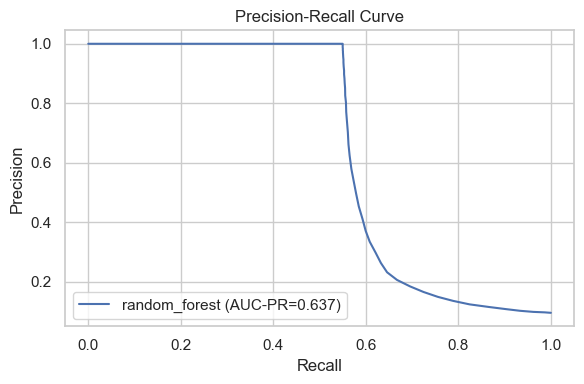

In [15]:
# Ensemble Model (XGBoost or Random Forest)
ensemble_model = train_ensemble_model(X_train_final, y_train_final, model_type="random_forest")  # or 'random_forest'
ensemble_eval = evaluate_model(ensemble_model, X_test, y_test, model_name="random_forest")

In [16]:
# Comparison
if ensemble_eval["f1"] > logistic_eval["f1"]:
    print("✅ XGBoost is better based on F1 Score and AUC-PR.")
else:
    print("✅ Logistic Regression is better for this dataset.")

✅ XGBoost is better based on F1 Score and AUC-PR.


In [17]:
# Comparison
if ensemble_eval["f1"] > logistic_eval["f1"]:
    print("✅ Random Forest is better based on F1 Score and AUC-PR.")
else:
    print("✅ Logistic Regression is better for this dataset.")

✅ Random Forest is better based on F1 Score and AUC-PR.


### Hyperparameter Tuning 

In [11]:
# Search & Save hyperparameters for Random Forest
search_best_params_rf(X_train_final, y_train_final)

{'max_depth': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [12]:
# Train Random Forest using best params
rf_model = train_rf_with_best(X_train_final, y_train_final)


--- Random Forest Evaluation ---
=== Model Evaluation ===
F1 Score: 0.7086834733893558
AUC-PR: 0.6382476703877006

Confusion Matrix:
[[35055     8]
 [ 1656  2024]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98     35063
           1       1.00      0.55      0.71      3680

    accuracy                           0.96     38743
   macro avg       0.98      0.77      0.84     38743
weighted avg       0.96      0.96      0.95     38743



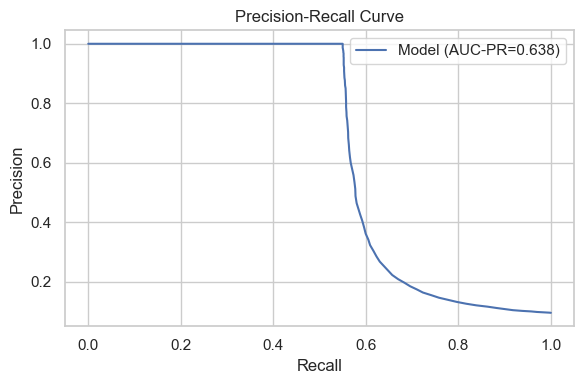

{'f1': 0.7086834733893558,
 'auc_pr': np.float64(0.6382476703877006),
 'confusion_matrix': array([[35055,     8],
        [ 1656,  2024]])}

In [13]:
# Evaluate
print("\n--- Random Forest Evaluation ---")
evaluate_model(rf_model, X_test, y_test)

In [ ]:
# Search & Save hyperparameters for XGBoost
search_best_params_xgb(X_train_final, y_train_final)

In [ ]:
# Train Random Forest using best params
xgb_model = train_xgb_with_best(X_train_final, y_train_final)

In [ ]:

# Step 3: Evaluate
print("\n--- Random Forest Evaluation ---")
evaluate_model(rf_model, X_test, y_test)

print("\n--- XGBoost Evaluation ---")
evaluate_model(xgb_model, X_test, y_test)

## Model Explainability